In [11]:
import os
import numpy as np
from collections import defaultdict
import json
import torch
import torch.nn as nn

from csng.data import get_dataloaders, get_sample_data
from csng.losses import FID, get_metrics
from csng.utils.mix import seed_all
from csng.utils.comparison import plot_reconstructions
from csng.utils.data import crop

In [12]:
### brainreader mouse data
cfg = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {"mixing_strategy": "sequential"},
    "crop_wins": dict(),
}
cfg["data"]["brainreader_mouse"] = {
    "device": cfg["device"],
    "mixing_strategy": cfg["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(os.environ["DATA_PATH"], "brainreader", "data"),
    "batch_size": 64,
    "sessions": [6],
    "resize_stim_to": (224, 224),
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,
}
# add crop_wins for brainreader mouse data
_dls, _ = get_dataloaders(config=cfg)
for data_key, dset in zip(_dls["train"]["brainreader_mouse"].data_keys, _dls["train"]["brainreader_mouse"].datasets):
    cfg["crop_wins"][data_key] = tuple(dset[0].images.shape[-2:])
    print(f"crop_wins[{data_key}]: {cfg['crop_wins'][data_key]}")
    

crop_wins[6]: (224, 224)


In [13]:
### evaluation function
def eval_decoder(model, dataloaders, loss_fns, crop_wins, calc_fid=False, max_batches=None):
    model.eval()

    ### for tracking over whole dataset
    losses = {data_key: {loss_fn_name: 0 for loss_fn_name in data_key_loss_fns.keys()} for data_key, data_key_loss_fns in loss_fns.items()}
    denom_data_keys = {}
    if calc_fid:
        preds, targets = defaultdict(list), defaultdict(list)

    ### run eval
    for k, dl in dataloaders.items(): # different data sources (cat_v1, mouse_v1, ...)
        for b in dl:
            ### combine losses from all data keys
            for dp in b:
                ### get predictions
                stim_pred = model(
                    dp["resp"],
                    data_key=dp["data_key"],
                    neuron_coords=dp["neuron_coords"],
                    pupil_center=dp["pupil_center"],
                )

                ### calc metrics
                for loss_fn_name, loss_fn in loss_fns[dp["data_key"]].items():
                    losses[dp["data_key"]][loss_fn_name] += loss_fn(stim_pred, dp["stim"], data_key=dp["data_key"], phase="val").item()

                ### append for later fid calculation
                if calc_fid:
                    preds[dp["data_key"]].append(crop(stim_pred, crop_wins[dp["data_key"]]).detach().cpu())
                    targets[dp["data_key"]].append(crop(dp["stim"], crop_wins[dp["data_key"]]).cpu())

                denom_data_keys[dp["data_key"]] = denom_data_keys[dp["data_key"]] + dp["stim"].shape[0] if dp["data_key"] in denom_data_keys else dp["stim"].shape[0]

            if max_batches is not None and b_idx + 1 >= max_batches:
                break

    ### average losses
    losses["total"] = defaultdict(float)
    for data_key in losses:
        if data_key == "total": continue
        for loss_name in losses[data_key]:
            losses[data_key][loss_name] /= denom_data_keys[data_key]
            losses["total"][loss_name] += losses[data_key][loss_name]
    losses["total"] = {loss_name: losses["total"][loss_name] / (len(losses.keys()) - 1) for loss_name in losses["total"]}

    ### eval fid
    if calc_fid:
        losses["total"]["FID"] = 0
        for data_key in preds.keys():
            fid = FID(inp_standardized=False, device="cpu")
            losses[data_key]["FID"] = fid(
                pred_imgs=torch.cat(preds[data_key], dim=0),
                gt_imgs=torch.cat(targets[data_key], dim=0)
            )
            losses["total"]["FID"] += losses[data_key]["FID"]
        losses["total"]["FID"] /= len(preds.keys())

    return losses

In [27]:
from csng.imagenet.models import ReadIn, UpsampleModel

### init decoder
READIN_PATH =  '/scratch/izar/vanousek/cs-433-project/models/readin/readin_2024-12-16_21-22-07.pt'
UPSAMPLE_PATH = '/scratch/izar/vanousek/cs-433-project/models/mlp2489100.pt'

class Decoder(nn.Module):
    def __init__(self, img_shape=(1, 36, 64)):
        super().__init__()
        self.readin = torch.load(READIN_PATH).to(cfg["device"], dtype=torch.float32)
        self.upsample = torch.load(UPSAMPLE_PATH)
    def forward(self, resp, **kwargs):
        return self.upsample(self.readin(resp))


decoder = Decoder().to(cfg["device"])

In [28]:
### eval
# prepare data and metrics
seed_all(cfg["seed"])
dls, _ = get_dataloaders(config=cfg)
metrics = {data_key: get_metrics(crop_win=cfg["crop_wins"][data_key], device=cfg["device"]) for data_key in cfg["crop_wins"].keys()}

# run evaluation
test_losses = eval_decoder(
    model=decoder,
    dataloaders=dls["test"],
    loss_fns=metrics,
    crop_wins=cfg["crop_wins"],
    calc_fid=True,
)["total"]

### save results
print(json.dumps(test_losses, indent=4))
torch.save(test_losses, "test_losses.pt")

/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /home/vanousek/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|███████████████████████████████████████████████████████████████████████████| 91.2M/91.2M [00:00<00:00, 109MB/s]


{
    "SSIM": 0.21005136966705323,
    "Log SSIML": 0.5081874847412109,
    "SSIML": 0.39497430324554444,
    "PL": 0.16861398220062257,
    "FFL": 0.08260277509689332,
    "MSE": 0.11253975629806519,
    "MSE-no-standardization": 2.2823266983032227,
    "MAE": 0.28740625381469725,
    "SSIML-PL": 0.563588285446167,
    "FID": 19.24714469909668
}


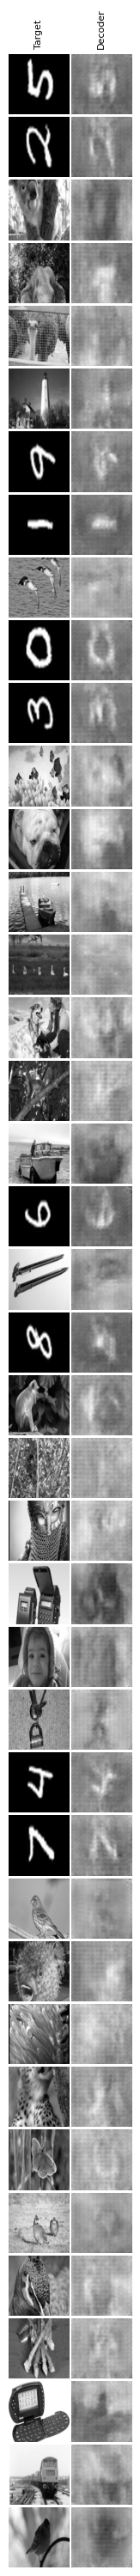

In [29]:
### get sample reconstructions
# sample data
seed_all(cfg["seed"])
dls, neuron_coords = get_dataloaders(config=cfg)
s = get_sample_data(dls=dls, config=cfg, sample_from_tier="test")

# get reconstructions
stim_pred = decoder(
    s["b_resp"].to(cfg["device"]),
    neuron_coords=neuron_coords[s["b_sample_dataset"]][s["b_sample_data_key"]],
    data_key=s["b_sample_data_key"],
).detach().cpu()

# plot reconstructions
plot_reconstructions(
    runs={
        "Decoder": {
            "stim_pred_best": [{s["b_sample_data_key"]: stim_pred}],
        }
    },
    stim=s["stim"],
    stim_label="Target",
    data_key=s["b_sample_data_key"],
    crop_win=cfg["crop_wins"][s["b_sample_data_key"]],
    save_to=f"reconstructions_{s['b_sample_data_key']}.pdf",
)